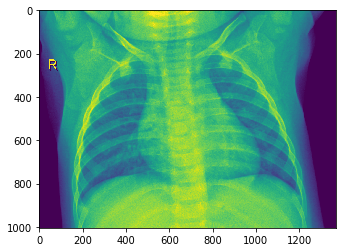

In [1]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPool2D,Dropout,Dense,Flatten
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tensorflow.keras.preprocessing.image import load_img,array_to_img, ImageDataGenerator
from PIL import Image
from sklearn.preprocessing import OneHotEncoder
import cv2
import time
encoder = OneHotEncoder()
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
image  = mpimg.imread("../Corona Chest X-Rays/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train/IM-0182-0001.jpeg")
imgplot = plt.imshow(image)
plt.show()

In [44]:
def preprocessData():
    print("Preprocessing Data...")
    train = pd.read_csv("../Corona Chest X-Rays/Chest_xray_Corona_Metadata.csv")
    test = pd.read_csv("../Corona Chest X-Rays/Chest_xray-Corona_Metadata_test.csv")
    train_directory = '../Corona Chest X-Rays/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train'
    test_directory = '../Corona Chest X-Rays/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/test'
   
    train['image'] = [s + ".jpeg" for s in train["X_ray_image_name"]]
    train['target_string'] = train['Label_1_Virus_category'].astype(str)
#    train.replace(np.nan,'Normal')
#   train.fillna(train)
    pd.get_dummies(train)
    train_cat = train['target_string']
    train_cat_1_hot = encoder.fit(train)
    train_df, validate_df = train_test_split(train, test_size=0.05, random_state=42)
    
    encoder.categories_
    
    test['image'] = [i + ".jpeg" for i in test["X_ray_image_name"]]
    test['target_string'] = test['Label_1_Virus_category'].astype(str)
    test_cat = test['target_string']
    
    train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
    
    train_generator = train_datagen.flow_from_dataframe(
        train_df,
        directory = train_directory,
        x_col = 'X_ray_image_name',
        y_col = 'target_string',
        target_size = (image_size,image_size),
        shuffle = True,
        classes = ['nan','Virus','bacteria'],
        class_mode='categorical',
        validate_filenames = False)
    
    validation_datagen = ImageDataGenerator(rescale=1./255)
    
    validation_generator = validation_datagen.flow_from_dataframe(
        validate_df, 
        directory = train_directory,
        x_col = 'X_ray_image_name',
        y_col = 'target_string',
        classes = ['nan','Virus','bacteria'],
        target_size = (image_size,image_size),
        shuffle = True,
        class_mode = 'categorical')
    
    test_datagen = ImageDataGenerator(rescale=1./255)
    
    test_generator = test_datagen.flow_from_dataframe(
        test,
        directory = test_directory,
        x_col = 'X_ray_image_name',
        y_col = 'target_string',
        classes = ['nan','Virus','bacteria'],
        target_size = (image_size,image_size),
        shuffle = True,
        class_mode = 'categorical')
    
    print("Finished Preprocessing")
    
    return train_generator, validation_generator, test_generator

In [3]:
class MoleNet:
    def build(image_size):
        model = Sequential() 
        
        model.add(Conv2D(32,(3,3), activation = 'relu', input_shape = (image_size,image_size,3))) 
        model.add(MaxPool2D((2,2))) 
        model.add(Dropout(rate=0.5))
        model.add(Conv2D(64,(3,3), activation = 'relu')) 
        model.add(MaxPool2D((2,2)))
        model.add(Dropout(rate=0.5))
        model.add(Conv2D(128,(3,3), activation = 'relu')) 
        model.add(MaxPool2D((2,2))) 
        model.add(Conv2D(256,(3,3), activation = 'relu')) 
        model.add(MaxPool2D((2,2))) 
        model.add(Flatten()) 
#        model.add(Dense(56, activation = 'relu'))
#        model.add(Dropout(rate=0.25))
#        model.add(Dense(512, activation = 'relu'))
#        model.add(Dropout(rate=0.25))
        model.add(Dense(256, activation = 'relu'))
        model.add(Dropout(rate=0.25))
        model.add(Dense(1, activation = 'sigmoid'))


        model.summary()
        return model

In [4]:
def trainModel(train_generator, validation_generator, training_batch_size, validation_batch_size, number_of_epochs,image_size, optimizer):
    print("Training Model...")
    
    model = MoleNet.build(image_size)
    model.compile(loss='binary_crossentropy',optimizer='Adam',metrics=['accuracy'])
    history = model.fit(train_generator, 
              steps_per_epoch= train_generator.samples//training_batch_size, 
              epochs=number_of_epochs,
              validation_data = validation_generator,
              validation_steps = validation_generator.samples//validation_batch_size)
    print("Model Trained")
    return model, history
    

In [5]:
def testModel(model,test_generator):
    
    test_scores = model.evaluate(test_generator, verbose=1,)
    
    print("Test loss:", test_scores[0])
    print("Test accuracy:", test_scores[1])
    
    return test_scores


In [6]:
training_batch_size = 100
validation_batch_size = 53
image_size = 128
number_of_epochs = 20
optimizer = tf.keras.optimizers.Adam(learning_rate=0.002)

In [43]:
train_generator, validation_generator, test_generator = preprocessData()

Preprocessing Data...


ValueError: Input contains NaN

In [27]:

model, history = trainModel(train_generator, validation_generator,training_batch_size, validation_batch_size, number_of_epochs,image_size, optimizer)


Training Model...
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 

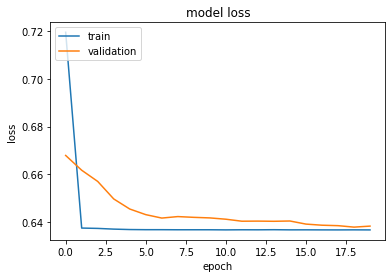

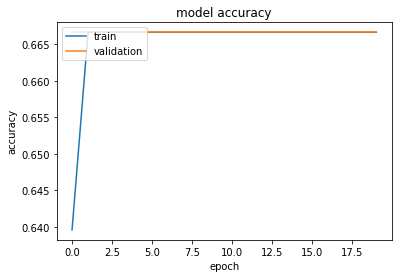

In [28]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


In [29]:
test_scores = testModel(model,test_generator)

20/20 [==============================] - 12s 595ms/step - loss: 0.6384 - accuracy: 0.6667
Test loss: 0.638367646932602
Test accuracy: 0.6666667


In [ ]:

img = tf.keras.preprocessing.image.load_img(
    "../Corona Chest X-Rays/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train/IM-0182-0001.jpeg", target_size=image_size)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]
print(
    "This image is %.2f percent normal and %.2f percent pnemonia."
    % (100 * (1 - score), 100 * score)
)

imgplot = plt.imshow(img)
plt.show()